In [5]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:80% !important; }</style>"))

In [6]:
import warnings
warnings.simplefilter(action='ignore')

In [4]:
import seaborn as sns
import matplotlib.mlab as ml
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.ticker as plticker

def stdfigsize(scale=1, nx=1, ny=1, ratio=1.3):
    """
    Returns a tuple to be used as figure size.
    -------
    returns (7*ratio*scale*nx, 7.*scale*ny)
    By default: ratio=1.3
    If ratio<0 them ratio = golden ratio
    """
    if ratio < 0:
        ratio = 1.61803398875
    return((7*ratio*scale*nx, 7*scale*ny))

def stdrcparams(usetex=False):
    """
    Set several mpl.rcParams and sns.set_style for my taste.
    ----
    usetex = True
    ----
    """
    sns.set_style("white")
    sns.set_style({"xtick.direction": "in",
                 "ytick.direction": "in"})
    rcparams = {'text.usetex': usetex,
              'font.family': 'sans-serif',
              'font.sans-serif': ['Helvetica'],
             # 'text.latex.unicode': True,
              'text.latex.preamble': [r"\usepackage[T1]{fontenc}",
                                      r"\usepackage{lmodern}",
                                      r"\usepackage{amsmath}",
                                      r"\usepackage{mathptmx}"
                                      ],
              'axes.labelsize': 30,
              'axes.titlesize': 30,
              'ytick.right': 'on',
              'xtick.top': 'on',
              'xtick.labelsize': '25',
              'ytick.labelsize': '25',
              'axes.linewidth': 1.8,
              'xtick.major.width': 1.8,
              'xtick.minor.width': 1.8,
              'xtick.major.size': 14,
              'xtick.minor.size': 7,
              'xtick.major.pad': 10,
              'xtick.minor.pad': 10,
              'ytick.major.width': 1.8,
              'ytick.minor.width': 1.8,
              'ytick.major.size': 14,
              'ytick.minor.size': 7,
              'ytick.major.pad': 10,
              'ytick.minor.pad': 10,
              'axes.labelpad': 15,
              'axes.titlepad': 15,
              "xtick.direction": "in",
              "ytick.direction": "in",
              'legend.fontsize': 20}
    mpl.rcParams.update(rcparams) 

mpl.rcParams['lines.linewidth'] = 5
mpl.rcParams['lines.color'] = '#3690c0'

stdrcparams(usetex=True)
figsize=stdfigsize(ratio=-1)
xs,ys=figsize

def custom_frame(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.tick_params(axis='x',length=10,direction='out')
    ax.tick_params(axis='x',which='minor',direction='out')
    ax.tick_params(axis='y',length=10,direction='out')
    ax.tick_params(axis='y',which='minor',direction='out')

In [7]:
import pickle
import itertools
import math
import random
import pandas as pd
import numpy as np
import networkx as nx

from datetime import date

In [8]:
def make_node_name(node):
    node = node.title()
    text = node.split('_')    
    if len(text)<3:
        return ','.join([text[0],text[1].upper()])
    else:
        city = ' '.join(text[0:-1])
        state = text[-1]
        state = state.upper()
        return ','.join([city,state])

In [9]:
df_air = pd.read_pickle('../data/networks/US_air_1990_2018.pkl')
nodes = set(df_air.source.unique())|set(df_air.target.unique())
df_air = df_air[df_air.source != df_air.target]
year = list(df_air.index.get_level_values(0).unique())
month = list(df_air.index.get_level_values(1).unique())
graphs_air = []
date_air = []
for y in year:
    for m in month:
#        if y != 2018 or m != 12:
        df = df_air.loc[y,m]
        date_air.append(date(y,m,1))
        G = nx.from_pandas_edgelist(df_air.loc[y,m], edge_attr=True)
        G.add_nodes_from(nodes)
        graphs_air.append(G)
        

n = date_air.index(date(2004,1,1))
graphs_air = graphs_air[n:]
date_air =  date_air[n:]

del df_air

In [10]:
import datetime
import calendar

def add_months(sourcedate, months):
    month = sourcedate.month - 1 + months
    year = sourcedate.year + month // 12
    month = month % 12 + 1
    day = min(sourcedate.day, calendar.monthrange(year,month)[1])
    return datetime.date(year, month, day)

In [11]:
import glob, os

files = glob.glob('../simulation2/results/*.pickle.dat')+ glob.glob('../simulation2/results0/*.pickle.dat')

In [385]:
df = pd.DataFrame()#{'time':[],'Nedges':[],'Gcc':[]})
N = graphs_air[-1].number_of_nodes()

for f in files:
    graphs_prediction = pickle.load(open(f,'rb'))
    df_temp = pd.DataFrame({})
    
    df_temp['time'] = [add_months(date_air[-1],j) for j in range(len(graphs_prediction))]
    df_temp['Nedges'] = [G.number_of_edges() for G in graphs_prediction]
    df_temp['Gcc'] = [max(nx.connected_component_subgraphs(G),key=len).number_of_nodes()/N for G in graphs_prediction]
    df_temp['Niso'] = [len(list(nx.isolates(G))) for G in graphs_prediction]
    if 'null' in f:
        df_temp['graph'] = ['null'] *len(graphs_prediction)
    else:
        df_temp['graph'] = ['model'] *len(graphs_prediction)
    df_temp['Fr'] = [f.strip('.pickle.dat').split('_')[-1][1:5]] *len(graphs_prediction)
    df = df.append(df_temp)

In [386]:
df.head()

,time,Nedges,Gcc,Niso,graph,Fr
0,2018-12-01,6016,0.389085,1204,null,0.04
1,2019-01-01,5918,0.388075,1206,null,0.04
2,2019-02-01,5831,0.387569,1207,null,0.04
3,2019-03-01,5749,0.385548,1211,null,0.04
4,2019-04-01,5658,0.385043,1212,null,0.04


In [10]:
temp = df[df.Fr=='0.06']
temp = temp[temp.graph=='model']
temp = temp[temp.time==date(2020,1,1)]
temp

,time,Nedges,Gcc,Niso,graph,Fr
13,2020-01-01,4277,0.332491,1306,model,0.06
13,2020-01-01,4323,0.325922,1309,model,0.06
13,2020-01-01,4404,0.335523,1296,model,0.06
13,2020-01-01,4288,0.329965,1302,model,0.06
13,2020-01-01,4373,0.339565,1293,model,0.06
13,2020-01-01,4339,0.329965,1304,model,0.06
13,2020-01-01,4384,0.335018,1308,model,0.06
13,2020-01-01,4322,0.341081,1296,model,0.06
13,2020-01-01,4437,0.338050,1287,model,0.06
13,2020-01-01,4428,0.332996,1303,model,0.06


In [387]:
df.Fr.unique()

array(['0.04', '0.06', '0.01', '0.08', '0.02'], dtype=object)

In [12]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit([[i] for i in range(len(graphs_air))], [G.number_of_edges() for G in graphs_air])

In [13]:
reg.coef_

array([-5.74719384])

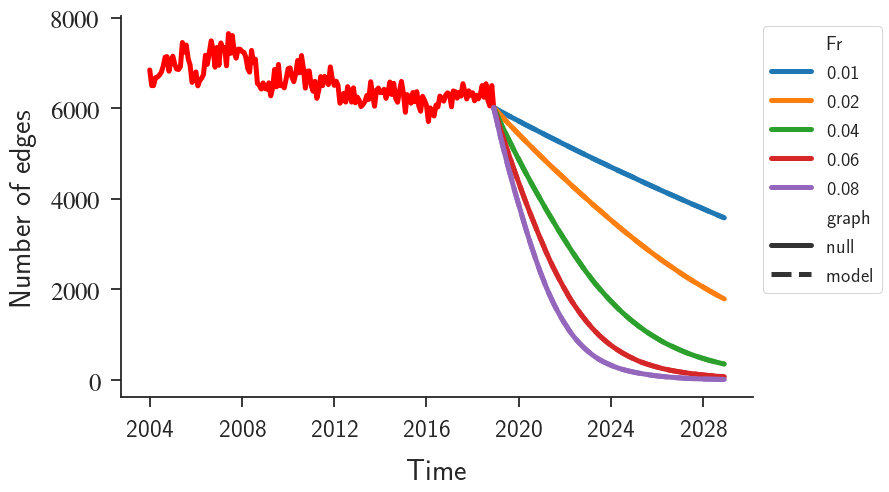

In [388]:
colors = sns.color_palette(None, 5)#['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0','#f0027f']
fig,ax = plt.subplots(figsize=(xs,ys))
plt.plot(date_air,[G.number_of_edges() for G in graphs_air],c='r')
ax = sns.lineplot(x="time", y="Nedges",hue='Fr', style='graph',palette=colors, legend = 'full', ci=95,n_boot=100,data=df)
plt.xlabel('Time')
plt.ylabel("Number of edges")
plt.legend(bbox_to_anchor=(1.0, 1))
custom_frame(ax)
plt.show()

## Simulations
Starting with the latest air transportation network we have in the data, using the model we trained to predict which edges are going to be removed. We simulate the removal of edges in next 10 years (120 time steps). At each time step, the model will assign a value (0-1) to each edge. We remove the edges by chance using this value model predicted and a control parameter f (approximately it's the fraction of removal each time step).
## Result
The figure shows how long each edges will be removed in those 10 simulations. The x axis is the edges index. The y axis is survial time (after how long it is removed). The solid line is the average survival time of the 10 simulations and the gred shaded area being the 90 conffident interval

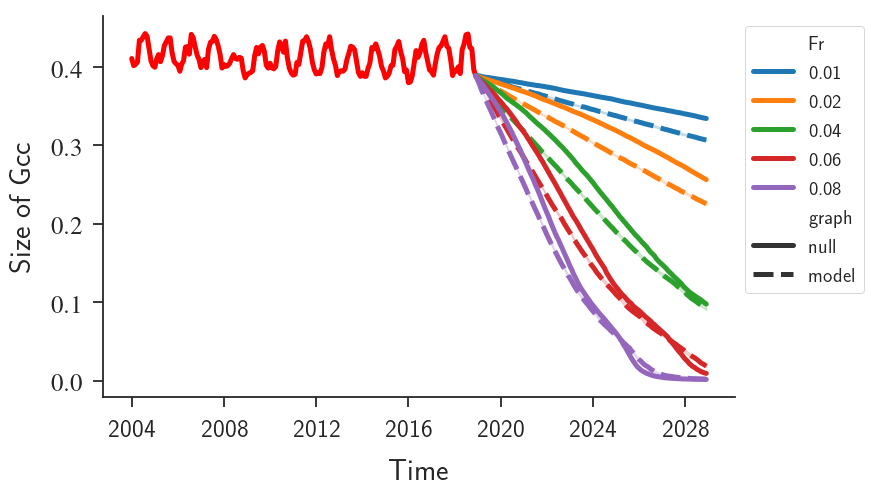

In [389]:
colors = sns.color_palette(None, 5)#['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0','#f0027f']
fig,ax = plt.subplots(figsize=(xs,ys))
plt.plot(date_air,[max(nx.connected_component_subgraphs(G),key=len).number_of_nodes()/N for G in graphs_air],c='r')
ax = sns.lineplot(x="time", y="Gcc",hue='Fr', style='graph',palette=colors, legend = 'full', data=df)
plt.xlabel('Time')
plt.ylabel("Size of Gcc")
plt.legend(bbox_to_anchor=(1.0, 1))
custom_frame(ax)
plt.show()

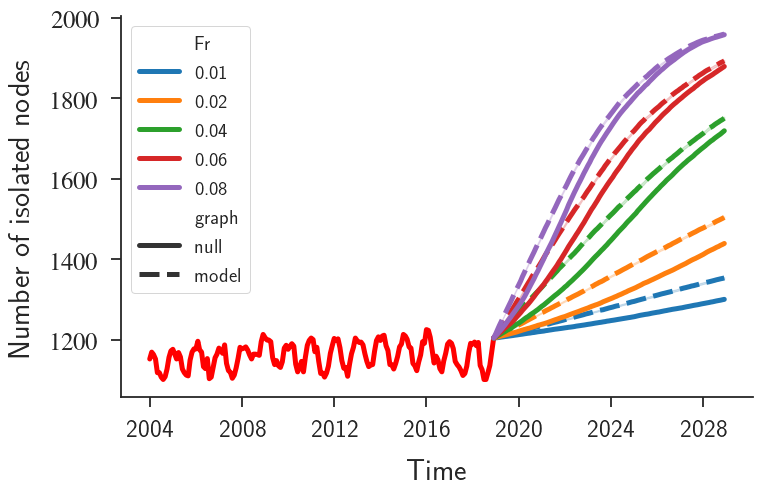

In [390]:
colors = sns.color_palette(None, 5)
fig,ax = plt.subplots(figsize=(xs,ys))
plt.plot(date_air,[len(list(nx.isolates(G))) for G in graphs_air],c='r')
ax = sns.lineplot(x="time", y="Niso",hue='Fr',style='graph',palette=colors, legend = 'full', data=df)
plt.xlabel('Time')
plt.ylabel("Number of isolated nodes")
custom_frame(ax)
plt.show()

In [12]:
from scipy.stats import sem, t
from scipy import mean

In [13]:
def plot_mean_and_CI(mean, lb, ub, color_mean=None, color_shading=None):
    # plot the shaded range of the confidence intervals
    plt.fill_between(range(len(mean)), ub, lb,
                     color=color_shading, alpha=.5)
    # plot the mean on top
    plt.plot(mean, color_mean)
    
def get_survival_time(Fr):
    
    G = pickle.load(open(f'../simulation2/results/model_graphs_F{Fr}0.pickle.dat','rb'))[0]
    edges_time = dict((edge,[]) for edge in list(G.edges()))
    files = glob.glob(f'../simulation2/results/model_graphs_F{Fr}*.pickle.dat') + glob.glob(f'../simulation2/results0/model_graphs_F{Fr}*.pickle.dat')
    for f in files:
        graphs = pickle.load(open(f,'rb'))
        for edge in list(G.edges()):
            a = sum([g.has_edge(*edge) for g in graphs])-1
            edges_time[edge].append(a) 
            
    G = pickle.load(open(f'../simulation2/results/model_graphs_null_F{Fr}0.pickle.dat','rb'))[0]
    edges_time_null = dict((edge,[]) for edge in list(G.edges()))
    files = glob.glob(f'../simulation2/results/model_graphs_null_F{Fr}*.pickle.dat')+glob.glob(f'../simulation2/results0/model_graphs_null_F{Fr}*.pickle.dat')
    for f in files:
        graphs = pickle.load(open(f,'rb'))
        for edge in list(G.edges()):
            a = sum([g.has_edge(*edge) for g in graphs])-1
            edges_time_null[edge].append(a) 
    
    confidence = 0.95
    x,y_mean,y_up,y_low = [],[],[],[]
    for e,v in edges_time.items():
        x.append(e)
        n=len(v)
        std_err = sem(v)
        m = np.mean(v)
        h = std_err * t.ppf((1 + confidence) / 2, n - 1)
        y_mean.append(m)
        y_up.append(m+h)
        y_low.append(m-h)
    
    x = [i for _,i in sorted(zip(y_mean,x))]
    y_up = [i for _,i in sorted(zip(y_mean,y_up))]
    y_low = [i for _,i in sorted(zip(y_mean,y_low))]
    y_mean = sorted(y_mean)
    
#     y_mean_null,y_up_null,y_low_null = [],[],[]
#     for e in x:
#         v=edges_time_null[e]
#         std_err = sem(v)
#         m = np.mean(v)
#         h = std_err * t.ppf((1 + confidence) / 2, n - 1)
#         y_mean_null.append(m)
#         y_up_null.append(m+h)
#         y_low_null.append(m-h)

    confidence = 0.95
    x_null,y_mean_null,y_up_null,y_low_null = [],[],[],[]
    for e,v in edges_time_null.items():
        x_null.append(e)
        std_err = sem(v)
        n=len(v)
        m = np.mean(v)
        h = std_err * t.ppf((1 + confidence) / 2, n - 1)
        y_mean_null.append(m)
        y_up_null.append(m+h)
        y_low_null.append(m-h)
        
    x_null = [i for _,i in sorted(zip(y_mean_null,x_null))]
    y_up_null = [i for _,i in sorted(zip(y_mean_null,y_up_null))]
    y_low_null = [i for _,i in sorted(zip(y_mean_null,y_low_null))]
    y_mean_null = sorted(y_mean_null)
    
    return(x,y_mean,y_up,y_low,x_null,y_mean_null,y_up_null,y_low_null)    

def plot_survival_time(Fr,data,model=True):
    if model:
        x,y_mean,y_up,y_low=data[0:4]
        title = f'Survival time of model with removal rate = {Fr}'
    else:
        x,y_mean,y_up,y_low=data[4::]
        title = f'Survival time of null model with removal rate = {Fr}'
    
    fig,ax=plt.subplots(figsize=(20,10))
    plot_mean_and_CI(y_mean, y_up, y_low, color_mean='k', color_shading='grey')

    index = x.index(('seattle_wa', 'santa_rosa_ca'))
    plt.scatter([index],[y_mean[index]],c='r',s=200,zorder=10)
    ax.annotate(f'({make_node_name(x[index][0])}' + ';\n' + f'{make_node_name(x[index][1])})',
                xy=(index, y_mean[index]), xycoords='data',size=20,
                xytext=(-65,100), textcoords='offset pixels',
                arrowprops=dict(arrowstyle="->",color='r'))


    index = x.index(('san_diego_ca', 'mountain_view_ca'))
    plt.scatter([index],[y_mean[index]],c='r',s=200,zorder=10)
    ax.annotate(f'({make_node_name(x[index][0])}' + ';\n' + f'{make_node_name(x[index][1])})',
                xy=(index, y_mean[index]), xycoords='data',size=20,
                xytext=(-80,-100), textcoords='offset pixels',
                arrowprops=dict(arrowstyle="->",color='r'))

    index = x.index(('orlando_fl','chicago_il'))
    plt.scatter([index],[y_mean[index]],c='r',s=200,zorder=10)
    ax.annotate(f'({make_node_name(x[index][0])}' + ';\n' + f'{make_node_name(x[index][1])})',
                xy=(index, y_mean[index]), xycoords='data',size=20,
                xytext=(-60,-50), textcoords='offset pixels',
                arrowprops=dict(arrowstyle="->",color='r'))



    index = x.index(('new_york_ny','chicago_il'))
    plt.scatter([index],[y_mean[index]],c='r',s=200,zorder=10)
    ax.annotate(f'({make_node_name(x[index][0])}' + ';\n' + f'{make_node_name(x[index][1])})',
                xy=(index, y_mean[index]), xycoords='data',size=20,
                xytext=(-60,10), textcoords='offset pixels',
                arrowprops=dict(arrowstyle="->",color='r'))
    plt.title(title)
    plt.xlabel('Edge index')
    plt.ylabel('Survival time (month)')
    plt.show()

In [14]:
data_1 = get_survival_time(0.01)

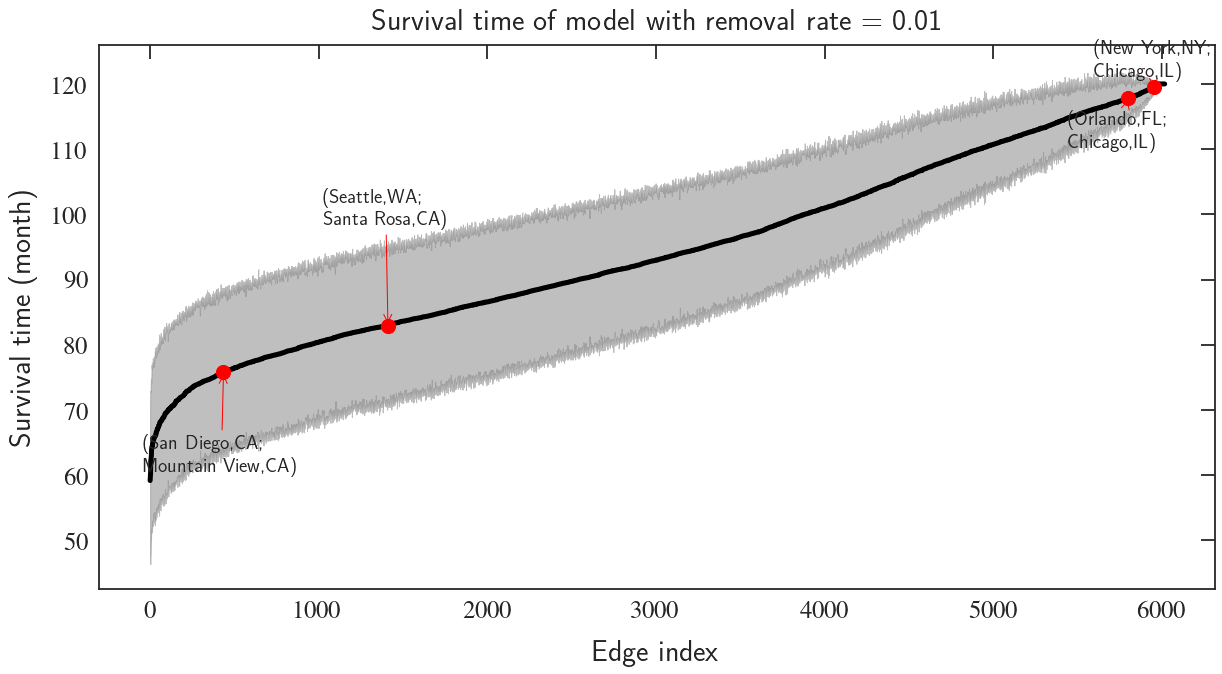

In [15]:
plot_survival_time(0.01,data_1,model = True)

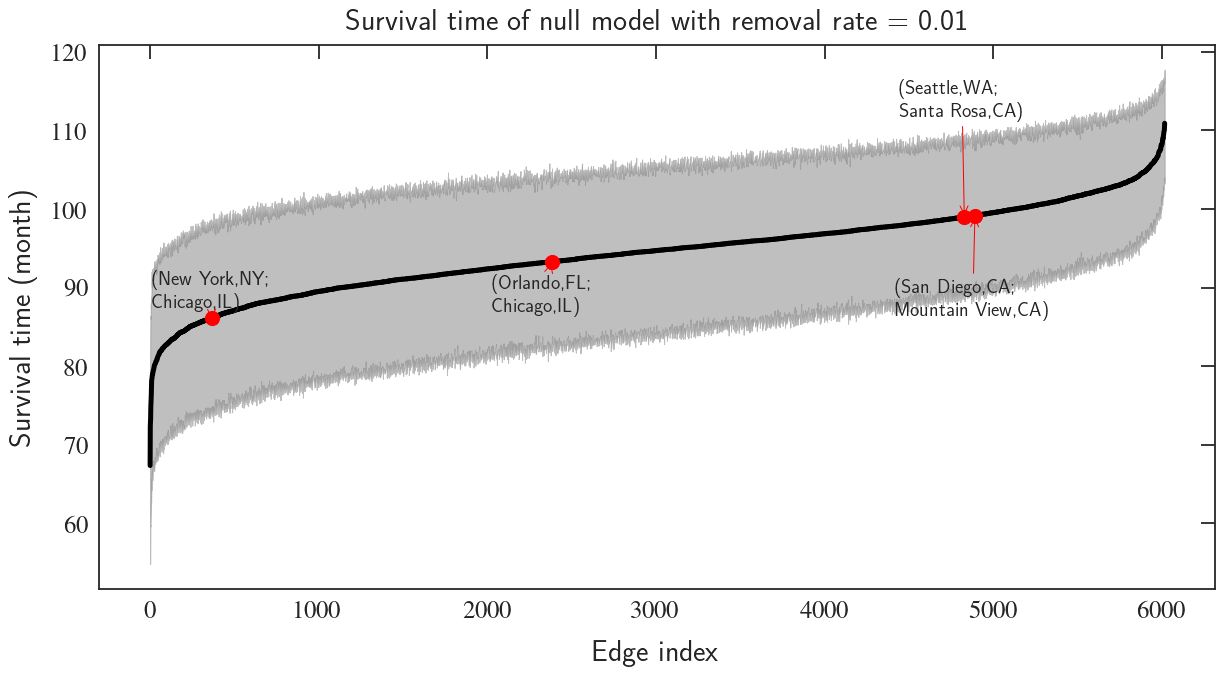

In [16]:
plot_survival_time(0.01,data_1,model = False)

In [399]:
data_2= get_survival_time(0.02)

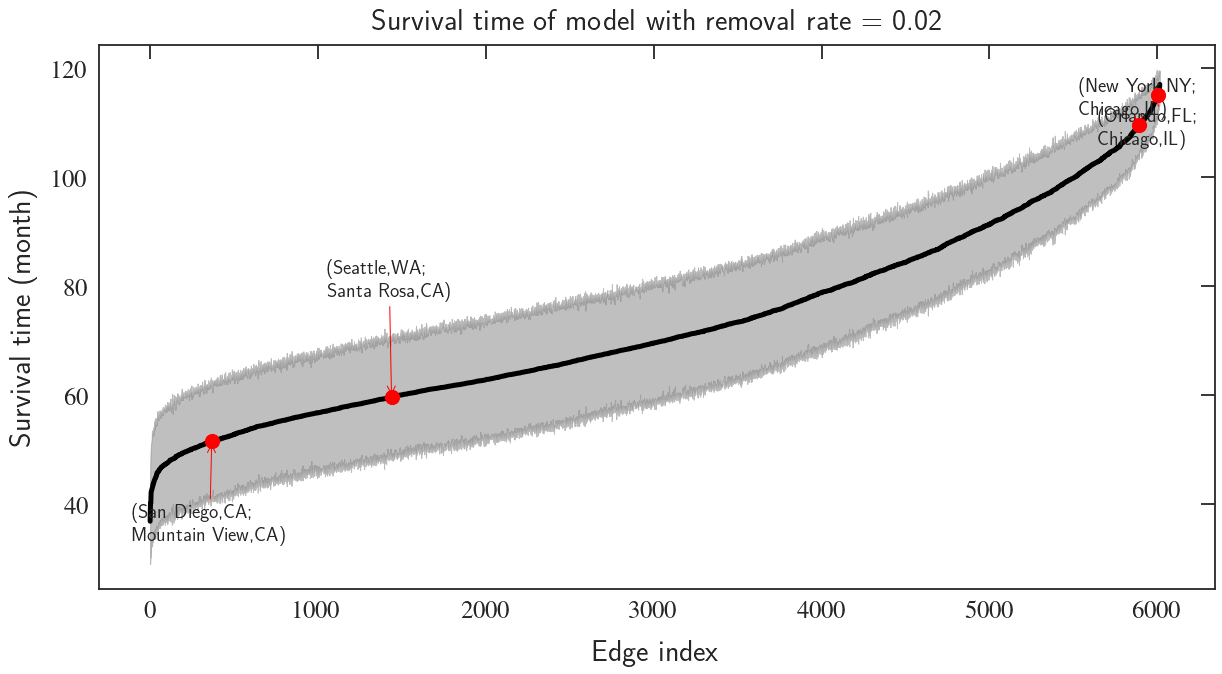

In [400]:
plot_survival_time(0.02,data_2,model=True)

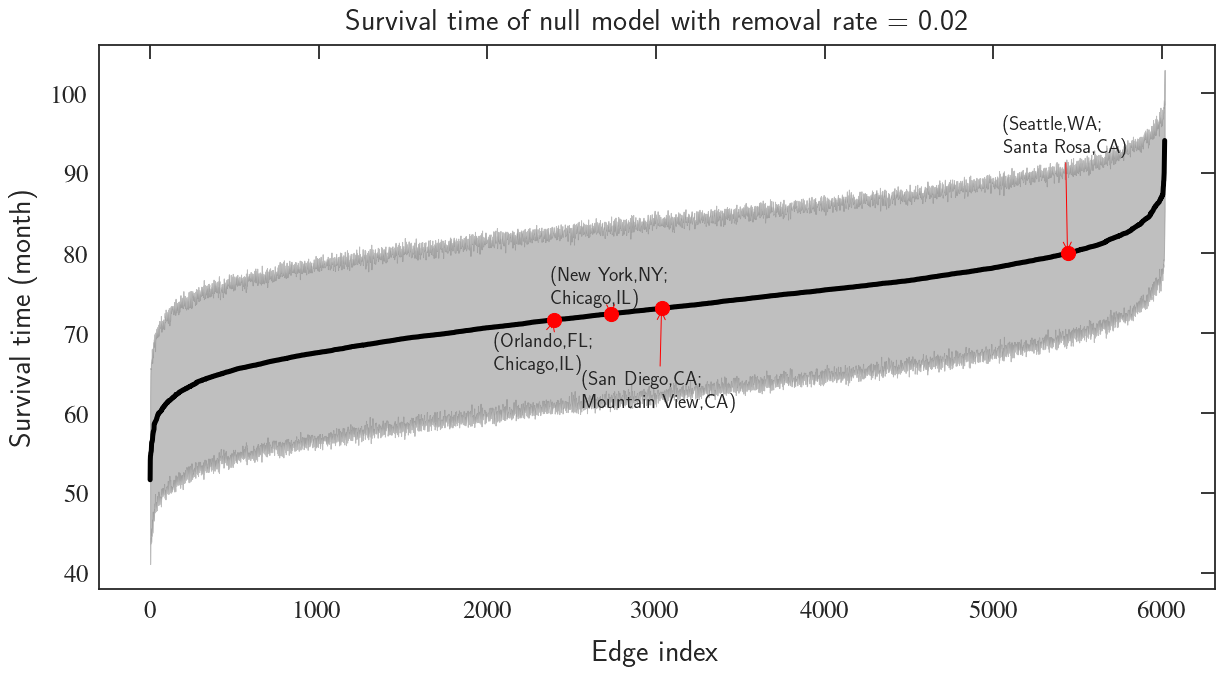

In [401]:
plot_survival_time(0.02,data_2,model=False)

In [402]:
data_4= get_survival_time(0.04)

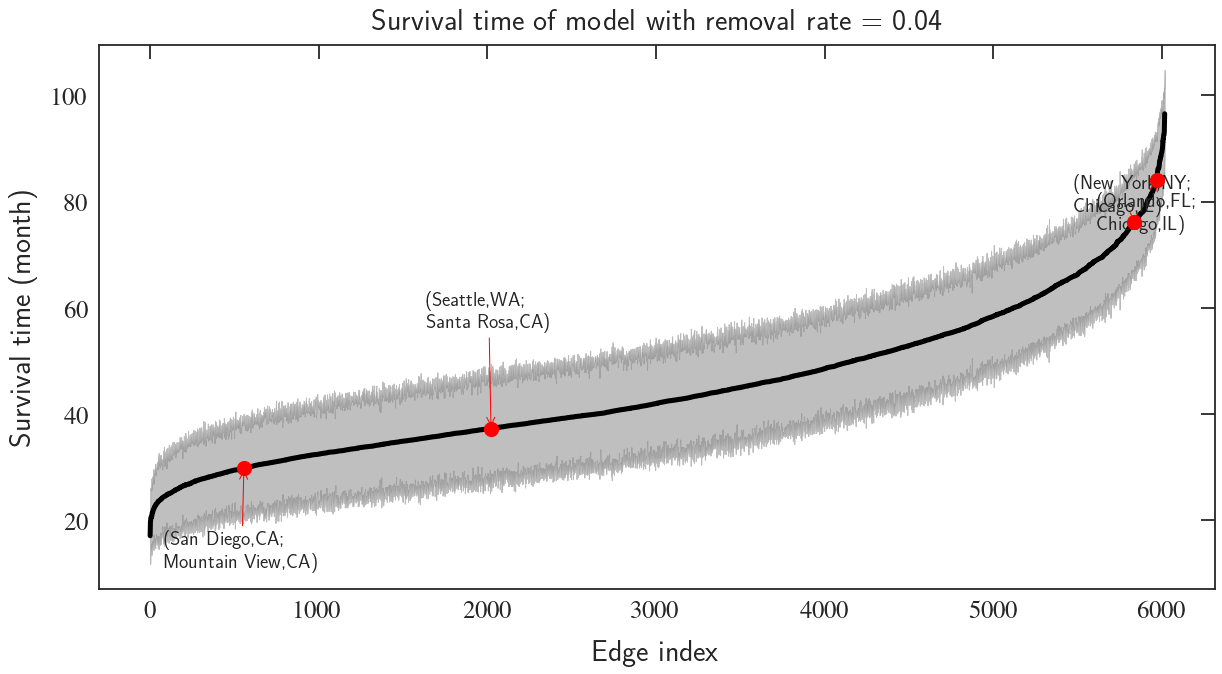

In [403]:
plot_survival_time(0.04,data_4,model=True)

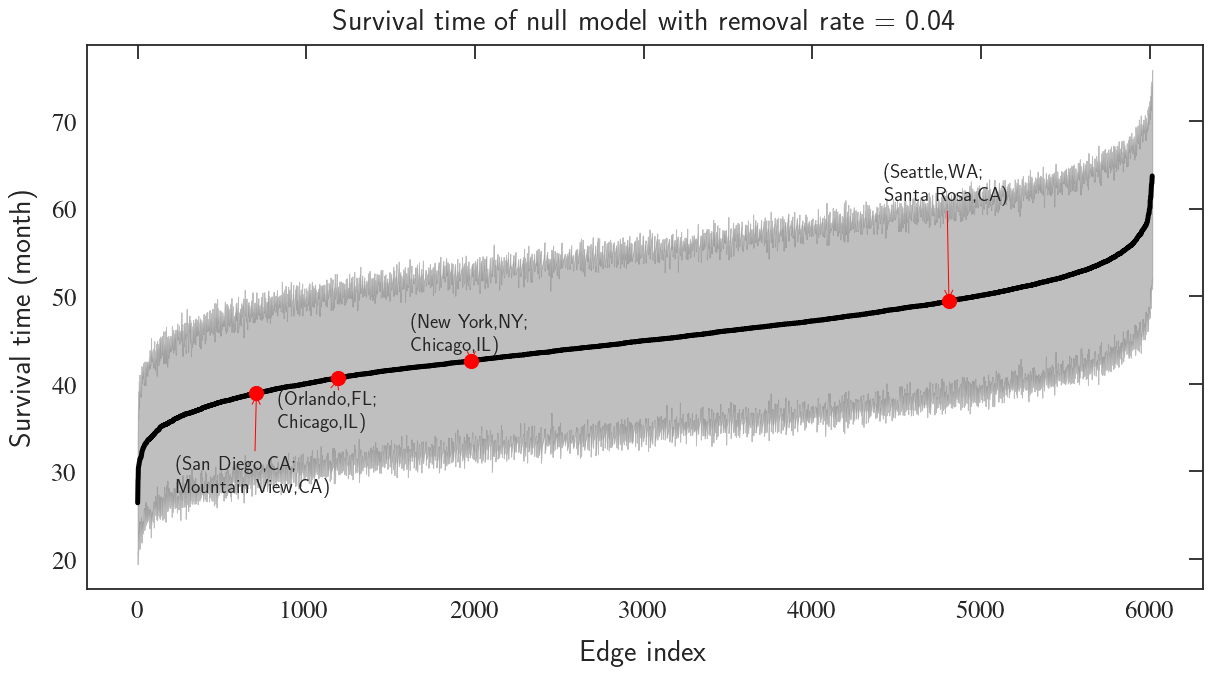

In [404]:
plot_survival_time(0.04,data_4,model=False)

In [405]:
data_6= get_survival_time(0.06)

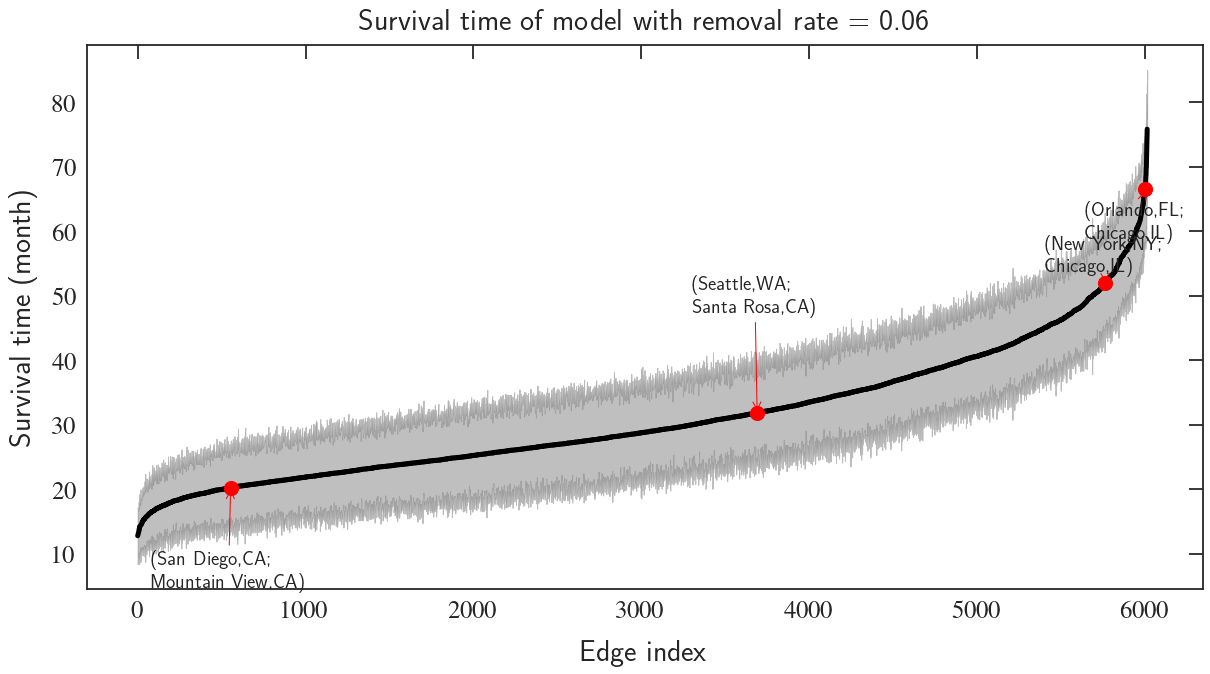

In [406]:
plot_survival_time(0.06,data_6,model=True)

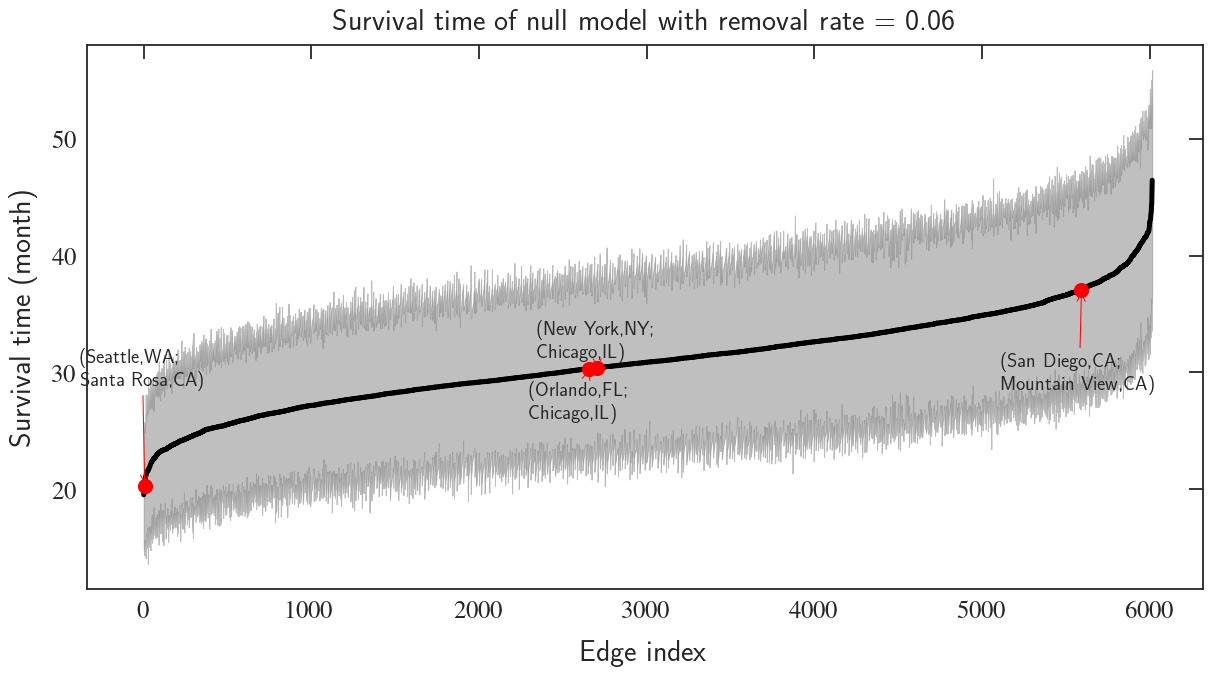

In [407]:
plot_survival_time(0.06,data_6,model=False)

In [408]:
data_8= get_survival_time(0.08)

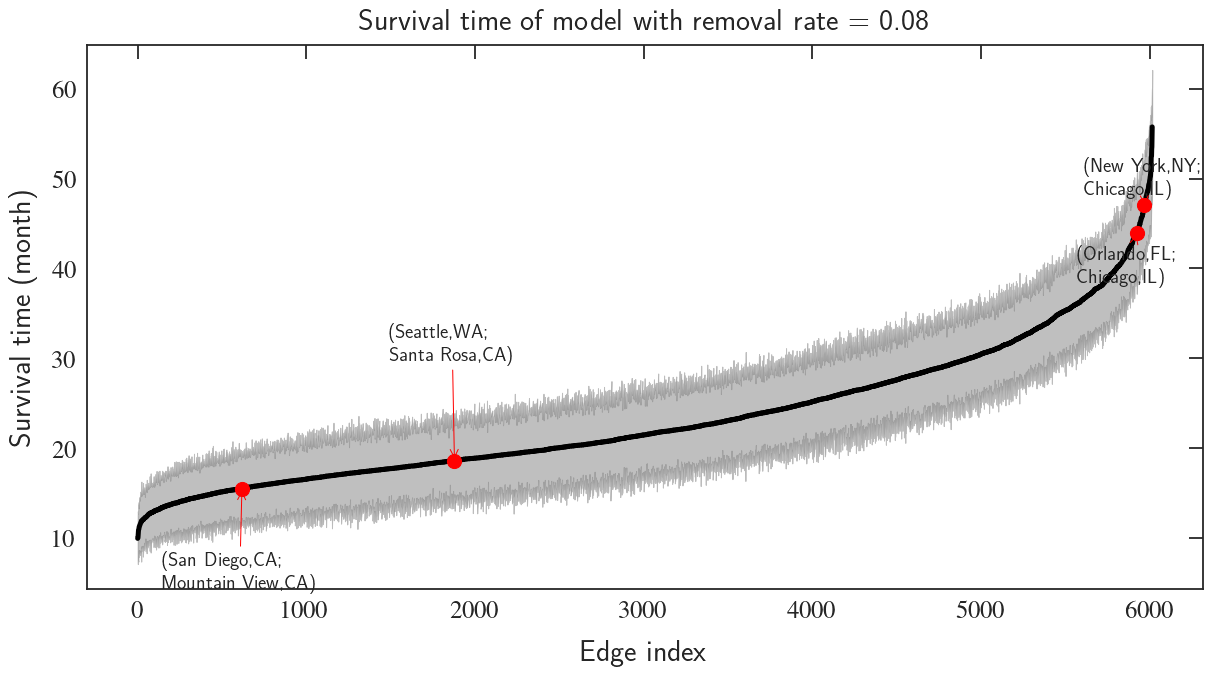

In [409]:
plot_survival_time(0.08,data_8,model=True)

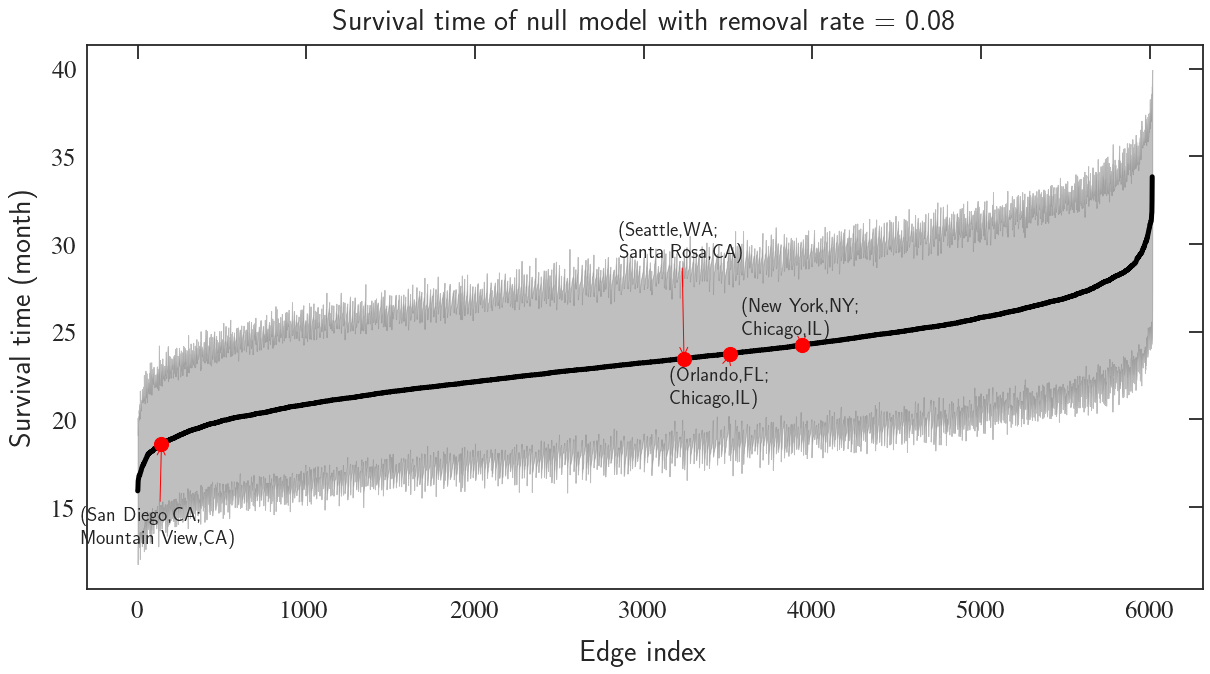

In [410]:
plot_survival_time(0.08,data_8,model=False)